In [1]:
using Distributions
using StatsPlots
default(fmt = :png, titlefontsize = 9, guidefontsize = 9)
using Roots

safediv(x, y) = x == 0 ? zero(x/y) : x/y
x ⪅ y = x < y || x ≈ y

function pvalue_clopper_pearson(k, n, p)
    bin = Binomial(n, p)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function pvalue_sterne(k, n, p)
    bin = Binomial(n, p)
    sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ pdf(bin, k))
end

function pvalue_wilson(k, n, p)
    phat = k/n
    sehat = √(p * (1 - p) / n)
    z = safediv(phat - p, sehat)
    2ccdf(Normal(), abs(z))
end

function pvalue_wald(k, n, p)
    phat = k/n
    sehat = √(phat * (1 - phat) / n)
    z = safediv(phat - p, sehat)
    2ccdf(Normal(), abs(z))
end

function pvalue_bayes_equal_tailed(k, n, p; α=1/3, β=1/3)
    beta = Beta(α + k, β + n - k)
    min(1, 2cdf(beta, p), 2ccdf(beta, p))
end

function pvalue_bayes_highest_density(k, n, p; α=1.0, β=1.0)
    0 < p < 1 || return zero(p)
    beta = Beta(α + k, β + n - k)
    m = α + k > 1 ? (β + n - k > 1 ? mode(beta) : 1.0) : 0.0
    p ≈ m && return one(p)
    t0 = (m + (p ≥ m ? 0 : 1))/2
    q = find_zero(t -> logpdf(beta, t) - logpdf(beta, p), t0)
    if q ≈ p
        if m == 0
            ccdf(beta, p)
        elseif m == 1
            cdf(beta, p)
        else
            min(cdf(beta, p), ccdf(beta, p))
        end
    else
        a, b = minmax(p, q)
        cdf(beta, a) + ccdf(beta, b)
    end
end

function plot_pvalue_functions(k, n;
        α_et=1/3, β_et=1/3,
        α_hd=1.0, β_hd=1.0,
        xlim=(eps(), 1-eps()), xtick=0:0.1:1,
        F=trues(6), kwargs...)
    f1(p) = pvalue_clopper_pearson(k, n, p)
    g1(p) = pvalue_sterne(k, n, p)
    h1(p) = pvalue_wilson(k, n, p)
    k1(p) = pvalue_wald(k, n, p)
    f2(p) = pvalue_bayes_equal_tailed(k, n, p; α=α_et, β=β_et)
    g2(p) = pvalue_bayes_highest_density(k, n, p; α=α_hd, β=β_hd)
    rd(x) = round(x; sigdigits=3)
    p = range(xlim..., 1000)
    plot()
    F[1] && plot!(p, f1; label="Clopper-Pearson", c=1)
    F[2] && plot!(p, g1; label="Sterne",          c=2)
    F[3] && plot!(p, h1; label="Wilson",          c=3)
    F[4] && plot!(p, k1; label="Wald",            c=4)
    F[5] && plot!(p, f2; label="Bayes equal-taild",     c=5, ls = :dash)
    F[6] && plot!(p, g2; label="Bayes highest density", c=6, ls = :dash)
    ttl = "P-value functions for (k, n) = ($k, $n)"
    F[5] && (ttl *= ", prior_et=($(rd(α_et)), $(rd(β_et)))")
    F[6] && (ttl *= ", prior_hd=($(rd(α_hd)), $(rd(β_hd)))")
    title!(ttl)
    plot!(; xlabel="p", ylabel="P-value")
    plot!(; xtick, ytick=0:0.05:1)
    plot!(; kwargs...)
end

plot_pvalue_functions (generic function with 1 method)

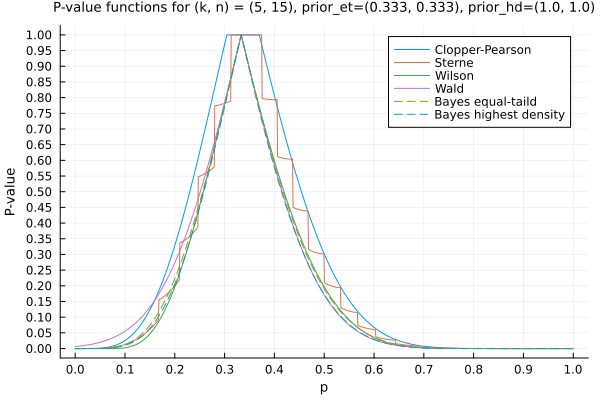

In [2]:
plot_pvalue_functions(5, 15;
    α_et=1/3, β_et=1/3,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 1.0), xtick=0:0.1:1,
    F=trues(6))

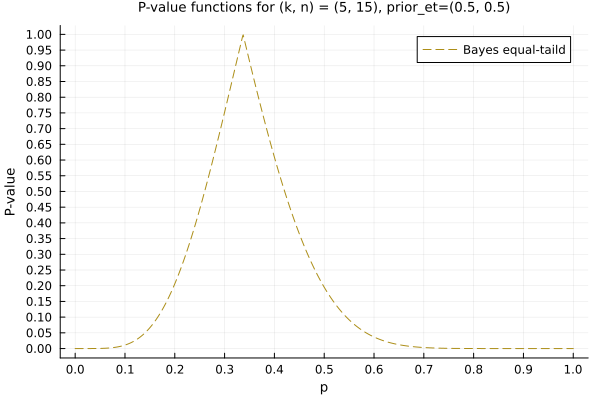

In [3]:
plot_pvalue_functions(5, 15;
    α_et=0.5, β_et=0.5,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 1.0), xtick=0:0.1:1,
    F=Bool[0,0,0,0,1,0])

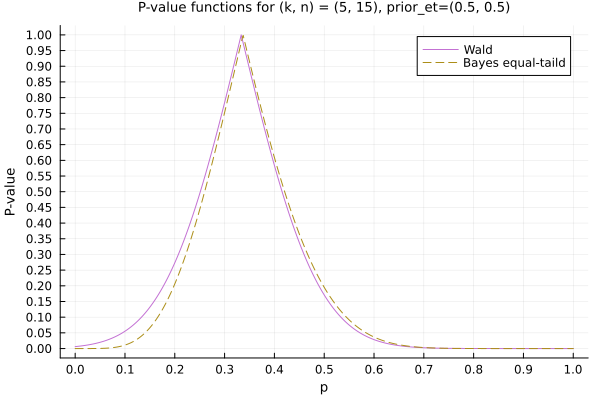

In [4]:
plot_pvalue_functions(5, 15;
    α_et=0.5, β_et=0.5,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 1.0), xtick=0:0.1:1,
    F=Bool[0,0,0,1,1,0])

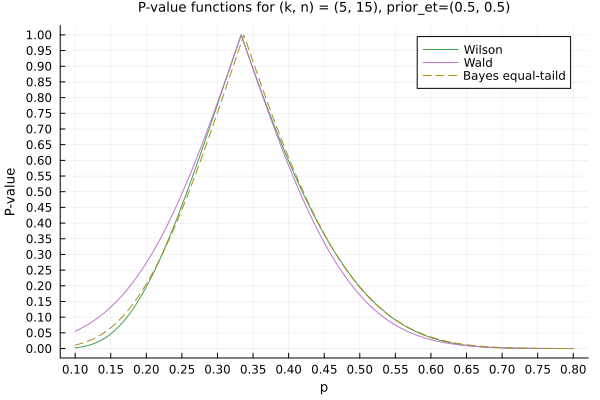

In [5]:
plot_pvalue_functions(5, 15;
    α_et=0.5, β_et=0.5,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.1, 0.8), xtick=0:0.05:1,
    F=Bool[0,0,1,1,1,0])

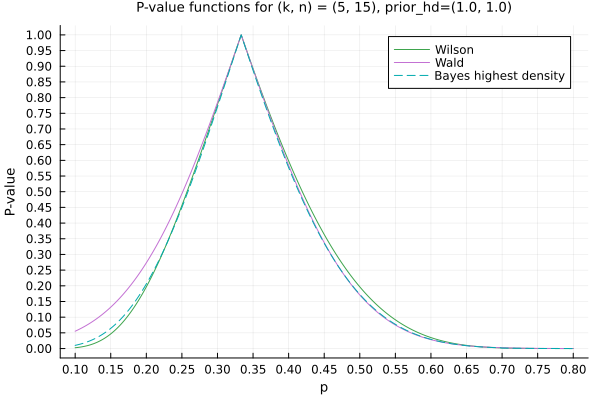

In [6]:
plot_pvalue_functions(5, 15;
    α_et=0.5, β_et=0.5,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.1, 0.8), xtick=0:0.05:1,
    F=Bool[0,0,1,1,0,1])

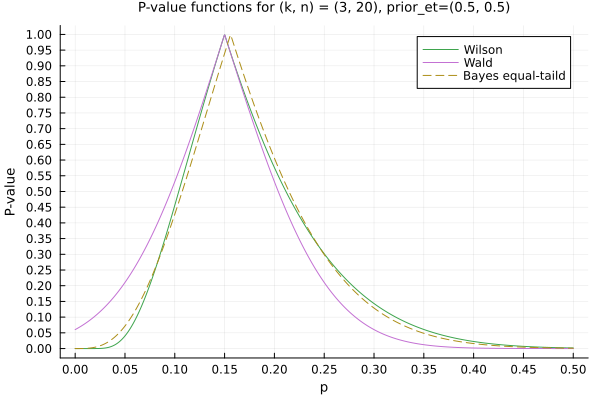

In [7]:
plot_pvalue_functions(3, 20;
    α_et=0.5, β_et=0.5,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 0.5), xtick=0:0.05:1,
    F=Bool[0,0,1,1,1,0])

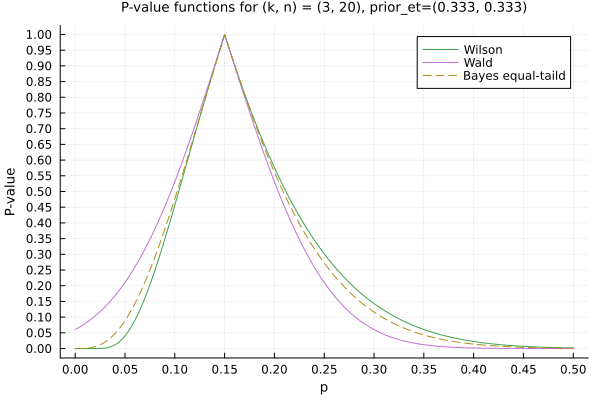

In [8]:
plot_pvalue_functions(3, 20;
    α_et=1/3, β_et=1/3,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 0.5), xtick=0:0.05:1,
    F=Bool[0,0,1,1,1,0])

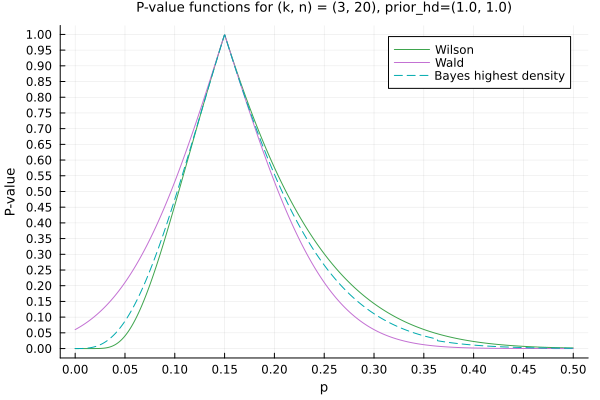

In [9]:
plot_pvalue_functions(3, 20;
    α_et=1/3, β_et=1/3,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 0.5), xtick=0:0.05:1,
    F=Bool[0,0,1,1,0,1])

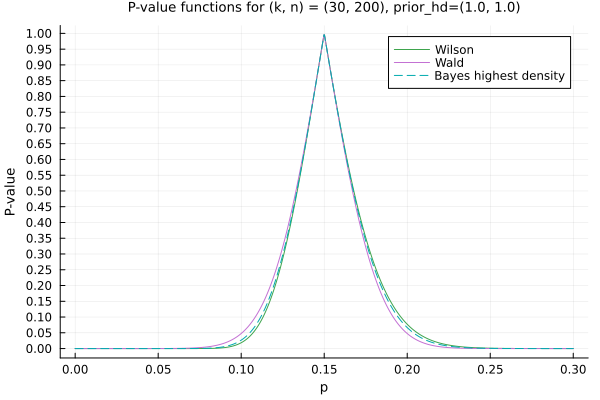

In [10]:
plot_pvalue_functions(30, 200;
    α_et=1/3, β_et=1/3,
    α_hd=1.0, β_hd=1.0,
    xlim=(0.0, 0.3), xtick=0:0.05:1,
    F=Bool[0,0,1,1,0,1])